In [1]:
import pandas as pd
import numpy as np
import os
import json
from scipy.stats import fisher_exact

# Load data

In [2]:
import pickle
infile = open("interaction_data.pkl",'rb')
d = pickle.load(infile)
infile.close()

infile = open("phase3_selections.pkl",'rb')
selected_item_interactions = pickle.load(infile)
infile.close()

infile = open("df_completed_participation.pkl",'rb')
df_completed_participation = pickle.load(infile)
infile.close()

In [3]:
def set_iteration(row):
    if row.interaction_type == "iteration-started" or row.interaction_type == "iteration-ended":
        row['iteration'] = json.loads(row.data)['iteration']
    else:
        row['iteration'] = None
    return row

def set_result_layout(row):
    if row.interaction_type == "iteration-started":
        row['result_layout'] = json.loads(row.data)['result_layout']
    else:
        row['result_layout'] = None
    return row

def set_mapping(row):
    if row.interaction_type == 'iteration-started':
        dat = json.loads(row.data)['algorithm_assignment'].values()
        for mapping in dat:
            row[mapping['name'].upper()] = mapping['order']
    else:
        row['GAMMA'] = None
        row['DELTA'] = None
    return row

In [4]:
d = d.apply(set_iteration, axis=1).apply(set_result_layout, axis=1).apply(set_mapping, axis=1)

In [5]:
d['iteration'] = d.groupby(['participation'], sort=False)['iteration'].apply(lambda x: x.ffill())

In [6]:
d['iteration'] = d.groupby(['participation'], sort=False)['iteration'].apply(lambda x: x.ffill())
d['result_layout'] = d.groupby(['participation'], sort=False)['result_layout'].apply(lambda x: x.ffill())
d['GAMMA'] = d.groupby(['participation'], sort=False)['GAMMA'].apply(lambda x: x.ffill())
d['DELTA'] = d.groupby(['participation'], sort=False)['DELTA'].apply(lambda x: x.ffill())

In [7]:
d = d[d.iteration.notna()]

In [8]:
def set_variant(x):
    if x.interaction_type == 'selected-item' or x.interaction_type == 'deselected-item':
        dat = json.loads(x.data)[x.interaction_type.replace('-', '_')]
        if 'variant' in dat:
            x['variant'] = dat['variant']
        else:
            x['variant'] = None
    else:
        x['variant'] = None
    return x

def set_selected_item(x):
    it = json.loads(x.data)
    if 'selected_item' not in it:
        if "deselected_item" in it:
            it = it['deselected_item']
        else:
            x['selected_item'] = None
            x['selected_item_coord'] = None
            return x
    else:
        it = it['selected_item']
    
    algo = 'GAMMA'
    assert x.variant == it['variant']
    if x.variant == x.DELTA:
        algo = 'DELTA'
    it_name = f"{algo}_{it['movie_idx']}"
    if it_name not in x['item_positions']:
        x['selected_item'] = None
        x['selected_item_coord'] = None
        x['selected_item_abs_coord'] = None
    else:
        x['selected_item'] = it_name
        x['selected_item_coord'] = x['item_positions'][x['selected_item']]
        x['selected_item_abs_coord'] = get_abs_coord(x['selected_item_coord'], x['viewport'])
    return x

In [9]:
d = d.dropna()

## Add high level layout information

In [10]:
d.loc[:, "high_level_layout"] = d.result_layout.map(lambda x: "rows" if x in ["rows", "row-single-scrollable", "row-single"] else "columns")

In [11]:
d.loc[:, "variant"] = d[d.interaction_type == "selected-item"].data.map(lambda x: json.loads(x)["selected_item"].get("variant", -1))

In [49]:
df_selections = d[d.interaction_type == "selected-item"]

In [50]:
# Add selection order to each selection
df_selections.loc[:, 'selection_order'] = df_selections.groupby(["participation","iteration"]).cumcount()+1

In [14]:
df_selections = df_selections.apply(set_variant, axis=1)
df_selections = df_selections[df_selections.variant.notna()]

df_selections.GAMMA = df_selections.GAMMA.astype(int)
df_selections.DELTA = df_selections.DELTA.astype(int)
df_selections.iteration = df_selections.iteration.astype(int)

## Analyze switches (JUMPS) per layout

In [15]:
def num_switches(x, result_layout):
    tmp = x[x.result_layout == result_layout]
    tmp = tmp.groupby(["participation", "iteration"])
    
    switches = []
    for _, row in tmp:
        #if x[0] == 229:
        #    print(f"index = {x}")
        #    print(row["variant"])
        #    #print(row["variant"].diff().sum(axis=0)) # Without abs we can see the direction of switch
        switches.append(np.abs(row["variant"].diff()).sum(axis=0))
    return switches

def num_switches_high_level(x, high_level_layout):
    tmp = x[x.high_level_layout == high_level_layout]
    tmp = tmp.groupby(["participation", "iteration"])
    
    switches = []
    for _, row in tmp:
        #if x[0] == 229:
        #    print(f"index = {x}")
        #    print(row["variant"])
        #    #print(row["variant"].diff().sum(axis=0)) # Without abs we can see the direction of switch
        switches.append(np.abs(row["variant"].diff()).sum(axis=0))
    return switches

def plot_switches(x3, result_layout):
    switches = num_switches(x3, result_layout)
    #plt.title(f"{result_layout} switches")
    
    plt.hist(switches, bins=np.arange(np.array(switches).min(), np.array(switches).max()+1)-0.5, label=result_layout)
    plt.xlim(xmin=-1.0, xmax = 12)
    plt.xticks(np.arange(-1, 12, 1))
    plt.legend()
    
    df_switches = pd.DataFrame(switches)
    print(df_switches.describe())
    print(f"Rounded switches mean: {np.round(df_switches.mean(), 3)}")

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_rel
for i in df_selections.result_layout.unique():
    for j in df_selections.result_layout.unique():
        if i!=j:
            dx = num_switches(df_selections, i)
            dy = num_switches(df_selections, j)
            print(i,j, ttest_ind(dx,dy))

row-single-scrollable columns Ttest_indResult(statistic=-3.5885699265867697, pvalue=0.0003824242965081339)
row-single-scrollable max-columns Ttest_indResult(statistic=-2.762499195965861, pvalue=0.006068794557634057)
row-single-scrollable rows Ttest_indResult(statistic=0.13057013283085744, pvalue=0.896195658317338)
row-single-scrollable column-single Ttest_indResult(statistic=-5.829897810258099, pvalue=1.2776836101838712e-08)
row-single-scrollable row-single Ttest_indResult(statistic=-1.1503403690047156, pvalue=0.25086262042789736)
columns row-single-scrollable Ttest_indResult(statistic=3.5885699265867697, pvalue=0.0003824242965081339)
columns max-columns Ttest_indResult(statistic=1.0553076439259998, pvalue=0.2920084224051299)
columns rows Ttest_indResult(statistic=3.996399851236159, pvalue=7.802872862926617e-05)
columns column-single Ttest_indResult(statistic=-3.2267537563693347, pvalue=0.0013615410137098796)
columns row-single Ttest_indResult(statistic=3.0669448735256024, pvalue=0.002

In [17]:
from scipy.stats import ttest_ind, ttest_rel
for i in df_selections.high_level_layout.unique():
    for j in df_selections.high_level_layout.unique():
        if i!=j:
            dx = num_switches_high_level(df_selections, i)
            dy = num_switches_high_level(df_selections, j)
            print(i,j, ttest_ind(dx,dy))

rows columns Ttest_indResult(statistic=-7.356203876057192, pvalue=3.816603389185729e-13)
columns rows Ttest_indResult(statistic=7.356203876057192, pvalue=3.816603389185729e-13)


                0
count  195.000000
mean     1.943590
std      2.051376
min      0.000000
25%      1.000000
50%      1.000000
75%      2.500000
max     11.000000
Rounded switches mean: 0    1.944
dtype: float64


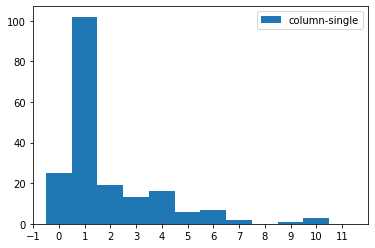

In [18]:
plot_switches(df_selections, "column-single")

                0
count  184.000000
mean     1.364130
std      1.352196
min      0.000000
25%      1.000000
50%      1.000000
75%      1.000000
max      9.000000
Rounded switches mean: 0    1.364
dtype: float64


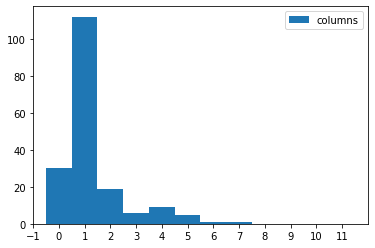

In [19]:
plot_switches(df_selections, "columns")

                0
count  170.000000
mean     1.223529
std      1.134468
min      0.000000
25%      1.000000
50%      1.000000
75%      1.000000
max      9.000000
Rounded switches mean: 0    1.224
dtype: float64


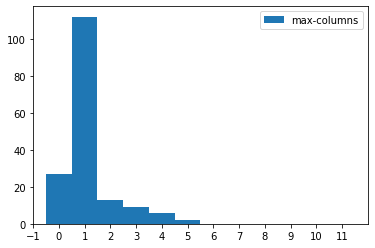

In [20]:
plot_switches(df_selections, "max-columns")

                0
count  178.000000
mean     0.932584
std      0.505288
min      0.000000
25%      1.000000
50%      1.000000
75%      1.000000
max      3.000000
Rounded switches mean: 0    0.933
dtype: float64


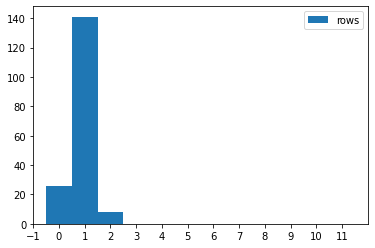

In [21]:
plot_switches(df_selections, "rows")

                0
count  171.000000
mean     1.017544
std      0.618097
min      0.000000
25%      1.000000
50%      1.000000
75%      1.000000
max      4.000000
Rounded switches mean: 0    1.018
dtype: float64


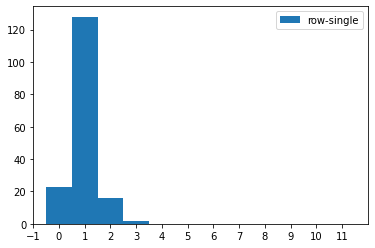

In [22]:
plot_switches(df_selections, "row-single")

                0
count  151.000000
mean     0.940397
std      0.580021
min      0.000000
25%      1.000000
50%      1.000000
75%      1.000000
max      3.000000
Rounded switches mean: 0    0.94
dtype: float64


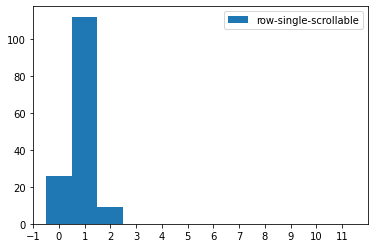

In [23]:
plot_switches(df_selections, "row-single-scrollable")

<AxesSubplot:title={'center':'Number of switches column-single'}>

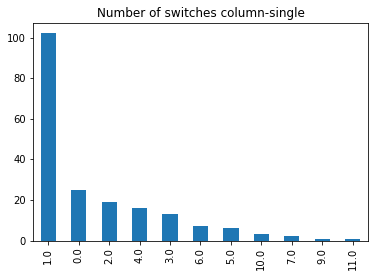

In [24]:
pd.Series(num_switches(df_selections, "column-single")).value_counts().plot(kind='bar', title="Number of switches column-single")

<AxesSubplot:title={'center':'Number of switches columns'}>

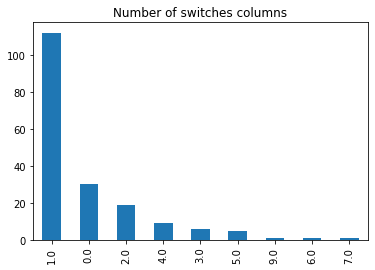

In [25]:
pd.Series(num_switches(df_selections, "columns")).value_counts().plot(kind='bar', title="Number of switches columns")

<AxesSubplot:title={'center':'Number of switches rows'}>

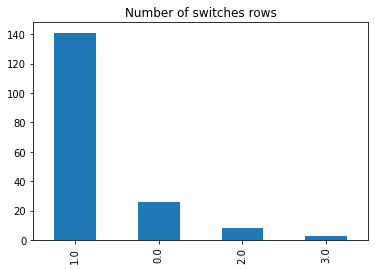

In [26]:
pd.Series(num_switches(df_selections, "rows")).value_counts().plot(kind='bar', title="Number of switches rows")

<AxesSubplot:title={'center':'Number of switches max-columns'}>

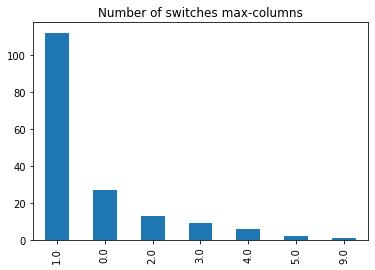

In [27]:
pd.Series(num_switches(df_selections, "max-columns")).value_counts().plot(kind='bar', title="Number of switches max-columns")

<AxesSubplot:title={'center':'Number of switches row-single'}>

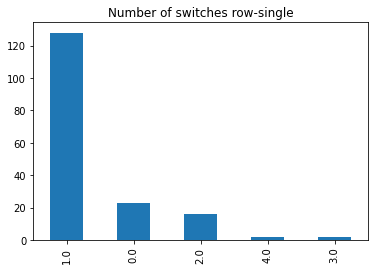

In [28]:
pd.Series(num_switches(df_selections, "row-single")).value_counts().plot(kind='bar', title="Number of switches row-single")

<AxesSubplot:title={'center':'Number of switches row-single-scrollable'}>

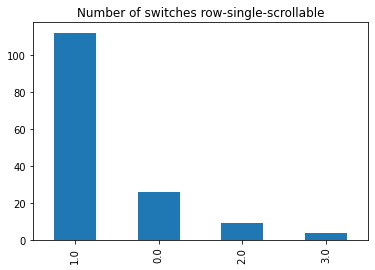

In [29]:
pd.Series(num_switches(df_selections, "row-single-scrollable")).value_counts().plot(kind='bar', title="Number of switches row-single-scrollable")

<AxesSubplot:title={'center':'Number of switches high level ROWS'}>

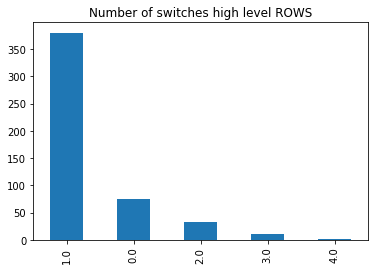

In [30]:
pd.Series(num_switches_high_level(df_selections, "rows")).value_counts().plot(kind='bar', title="Number of switches high level ROWS")

<AxesSubplot:title={'center':'Number of switches high level COLUMNS'}>

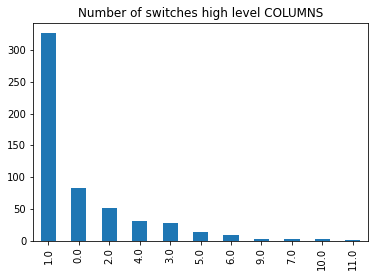

In [31]:
pd.Series(num_switches_high_level(df_selections, "columns")).value_counts().plot(kind='bar', title="Number of switches high level COLUMNS")

In [32]:
df = pd.DataFrame()
df.loc[:, "rows"] = pd.Series(num_switches_high_level(df_selections, "rows"))
df.loc[:, "columns"] = pd.Series(num_switches_high_level(df_selections, "columns"))
df

,rows,columns
0,1.0,0.0
1,0.0,1.0
2,1.0,0.0
3,0.0,0.0
4,1.0,2.0
...,...,...
494,1.0,1.0
495,1.0,2.0
496,2.0,4.0
497,1.0,0.0


In [33]:
from scipy.stats import ttest_ind
ttest_ind(pd.Series(num_switches_high_level(df_selections, "rows")), pd.Series(num_switches_high_level(df_selections, "columns")))

Ttest_indResult(statistic=-7.356203876057192, pvalue=3.816603389185729e-13)

In [34]:
df_results = pd.DataFrame(columns=["switches", "occurrences", "layout"])

for row_switches in pd.Series(num_switches_high_level(df_selections, "rows")):
    if row_switches > 1:
        df_results.loc[len(df_results.index)] = ["switches > 1", 1, "rows"]
    else:
        df_results.loc[len(df_results.index)] = ["switches <= 1", 1, "rows"]
        
for column_switches in pd.Series(num_switches_high_level(df_selections, "columns")):
    if column_switches > 1:
        df_results.loc[len(df_results.index)] = ["switches > 1", 1, "columns"]
    else:
        df_results.loc[len(df_results.index)] = ["switches <= 1", 1, "columns"]

df_results

,switches,occurrences,layout
0,switches <= 1,1,rows
1,switches <= 1,1,rows
2,switches <= 1,1,rows
3,switches <= 1,1,rows
4,switches <= 1,1,rows
...,...,...,...
1043,switches <= 1,1,columns
1044,switches <= 1,1,columns
1045,switches <= 1,1,columns
1046,switches <= 1,1,columns


In [35]:
cont = pd.crosstab(df_results.switches, df_results.layout).T
cont

switches,switches <= 1,switches > 1
layout,,
columns,408,141
rows,455,44


In [36]:
np.round(cont / np.stack([cont.sum(axis=1).values, cont.sum(axis=1).values]).T * 100, 1)

switches,switches <= 1,switches > 1
layout,,
columns,74.3,25.7
rows,91.2,8.8


In [37]:
from statsmodels.stats.proportion import proportions_ztest
for c1 in cont.index.unique():
    for c2 in cont.index.unique():
        if c1 != c2:
            cx = cont.loc[c1]
            cy = cont.loc[c2]
            succ = [cx[1], cy[1]]
            nobs = [cx[0] + cx[1], cy[0] + cy[1]]
            print(c1, c2, proportions_ztest(succ, nobs))

columns rows (7.151927606996008, 8.55676951305154e-13)
rows columns (-7.151927606996008, 8.55676951305154e-13)


In [38]:
df_results = pd.DataFrame(columns=["switches", "occurrences", "layout"])

for layout in df_selections.result_layout.unique():
    for switches in pd.Series(num_switches(df_selections, layout)):
        if switches > 1:
            df_results.loc[len(df_results.index)] = ["switches > 1", 1, layout]
        else:
            df_results.loc[len(df_results.index)] = ["switches <= 1", 1, layout]
df_results

,switches,occurrences,layout
0,switches <= 1,1,row-single-scrollable
1,switches <= 1,1,row-single-scrollable
2,switches <= 1,1,row-single-scrollable
3,switches > 1,1,row-single-scrollable
4,switches <= 1,1,row-single-scrollable
...,...,...,...
1044,switches <= 1,1,row-single
1045,switches <= 1,1,row-single
1046,switches <= 1,1,row-single
1047,switches > 1,1,row-single


In [39]:
cont2 = pd.crosstab(df_results.switches, df_results.layout).T
cont2

switches,switches <= 1,switches > 1
layout,,
column-single,127,68
columns,142,42
max-columns,139,31
row-single,151,20
row-single-scrollable,138,13
rows,167,11


In [40]:
np.round(cont2 / np.stack([cont2.sum(axis=1).values, cont2.sum(axis=1).values]).T * 100, 1)

switches,switches <= 1,switches > 1
layout,,
column-single,65.1,34.9
columns,77.2,22.8
max-columns,81.8,18.2
row-single,88.3,11.7
row-single-scrollable,91.4,8.6
rows,93.8,6.2


In [41]:
for c1 in cont2.index.unique():
    for c2 in cont2.index.unique():
        if c1 != c2:
            cx = cont2.loc[c1]
            cy = cont2.loc[c2]
            succ = [cx[1], cy[1]]
            nobs = [cx[0] + cx[1], cy[0] + cy[1]]
            print(c1, c2, proportions_ztest(succ, nobs))

column-single columns (2.582293890669529, 0.009814596681364664)
column-single max-columns (3.566085627009654, 0.00036235302119809617)
column-single row-single (5.176408732646106, 2.2619762505859593e-07)
column-single row-single-scrollable (5.72156496996728, 1.0554728111981278e-08)
column-single rows (6.774162815230879, 1.2512869607938399e-11)
columns column-single (-2.582293890669529, 0.009814596681364664)
columns max-columns (1.0666160358329162, 0.2861452562551501)
columns row-single (2.7599022253303263, 0.005781866304199897)
columns row-single-scrollable (3.495117282666145, 0.0004738534856907359)
columns rows (4.478927630374807, 7.501895982082622e-06)
max-columns column-single (-3.566085627009654, 0.00036235302119809617)
max-columns columns (-1.0666160358329162, 0.2861452562551501)
max-columns row-single (1.6929834143533096, 0.09045862425096317)
max-columns row-single-scrollable (2.5029150198834516, 0.012317511563542344)
max-columns rows (3.450838473432558, 0.0005588479271761014)
row